Implementing AutoRec, Deep AutoEncoders for CF (improvement over AutoRec) (approved by sir)

# MODEL

In [ ]:
! pip install tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model

In [2]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [3]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     

def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     
def masked_se(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse
def masked_se_clip_10(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse     

def masked_mse(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
     

def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse
     

def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

def masked_mse_clip_10(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
def masked_rmse_clip_10(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

##AutoRec

In [4]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU

In [5]:
def AutoRec(X, reg, first_activation, last_activation):
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

## books dataset

In [ ]:
datContent = [i.strip().split() for i in open("book_ratings.dat").readlines()][1:]

In [ ]:
max_user=0
max_book=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_book=max(max_book,int(r[1]))
print(max_book,max_user)

17384 2945


## U-AutoRec

In [ ]:
def my_proc(cont,init_val):
  matrix = np.full((max_user,max_book),init_val)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  return matrix

def my_proc_avg(cont): 
  matrix = np.full((max_user,max_book),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [ ]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 

In [ ]:
print(len(train_df),len(test_df),len(validate_df))

50751 6266 5639


In [ ]:
init_v = 5
users_items_matrix_train_zero = my_proc(train_df,init_v)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df,init_v)
users_items_matrix_test = my_proc(test_df,init_v)

In [ ]:
users_items_matrix_train_zero.shape

(2945, 17384)

In [ ]:
model = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10,masked_se_clip_10])
 
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 17384)]           0         
                                                                 
 LatentSpace (Dense)         (None, 500)               8692500   
                                                                 
 UserScorePred (Dense)       (None, 17384)             8709384   
                                                                 
Total params: 17,401,884
Trainable params: 17,401,884
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec = model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])

In [ ]:
test_result = model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

93/93 [==============================] - 3s 31ms/step - loss: 3.8000 - masked_mse_clip_10: 3.0306 - masked_rmse_clip_10: 0.9538 - masked_se_clip_10: 14.8020
[3.8000221252441406, 3.0306003093719482, 0.9538436532020569, 14.80201244354248]


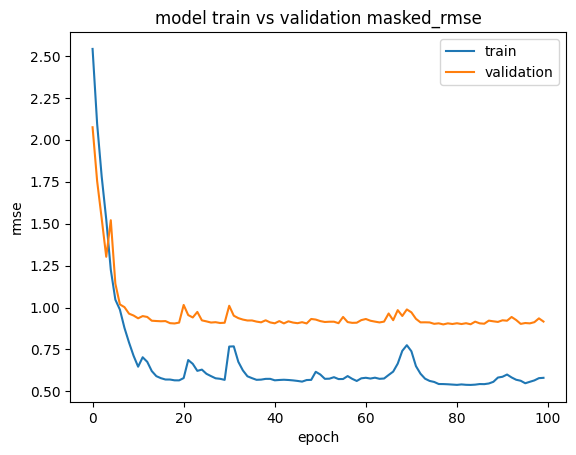

In [ ]:
rmse = hist_Autorec.history['masked_rmse_clip_10']
val_rmse = hist_Autorec.history['val_masked_rmse_clip_10']
plt.plot(np.arange(0, len(rmse), 1), rmse[0:])
plt.plot(np.arange(0, len(val_rmse), 1), val_rmse[0:])
plt.title('model train vs validation masked_rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

#Tuning hyperparameters

In [ ]:
activations=['linear','sigmoid','relu']
for outer_activation in activations:
  for inner_activation in activations:
    model = AutoRec(users_items_matrix_train_zero, 0.0005, outer_activation,inner_activation)
    model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
    hist_Autorec = model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 0, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
    test_result = model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
    print("first: ", outer_activation,"sec: ",inner_activation)
    print(test_result)

# I-Autorec

In [ ]:
def my_proc_2(cont,val):
  matrix = np.full((max_book,max_user),val)
  for r in cont:
    matrix[int(r[1])-1,int(r[0])-1] = float(r[2])
  return matrix

def my_proc_avg_2(cont): 
  matrix = np.full((max_book,max_user),0)
  for r in cont:
    matrix[int(r[1])-1,int(r[0])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [ ]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 

In [ ]:
print(len(train_df),len(test_df),len(validate_df))

50751 6266 5639


In [ ]:
init_v = 0
users_items_matrix_train_zero = my_proc_2(train_df,0)
users_items_matrix_train_five = my_proc_2(train_df,init_v)
users_items_matrix_train_avg = my_proc_avg_2(train_df)
users_items_matrix_validate = my_proc_2(validate_df,init_v)
users_items_matrix_test = my_proc_2(test_df,init_v)

In [ ]:
users_items_matrix_train_zero.shape

(17384, 2945)

In [ ]:
model2 = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

model2.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10,masked_se_clip_10])
 
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 2945)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1473000   
                                                                 
 UserScorePred (Dense)       (None, 2945)              1475445   
                                                                 
Total params: 2,948,445
Trainable params: 2,948,445
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec2 = model2.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])

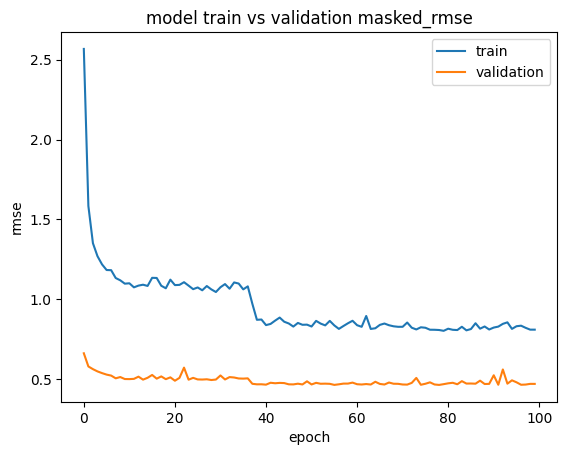

In [ ]:
rmse = hist_Autorec2.history['masked_rmse_clip_10']
val_rmse = hist_Autorec2.history['val_masked_rmse_clip_10']
plt.plot(np.arange(0, len(rmse), 1), rmse[0:])
plt.plot(np.arange(0, len(val_rmse), 1), val_rmse[0:])
plt.title('model train vs validation masked_rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
test_result = model2.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

544/544 [==============================] - 4s 7ms/step - loss: 2.6396 - masked_mse_clip_10: 2.0863 - masked_rmse_clip_10: 0.5050 - masked_se_clip_10: 2.4935
[2.6396162509918213, 2.0862669944763184, 0.5050160884857178, 2.4935083389282227]


# Tuning hyperparameters

In [ ]:
import gc

In [ ]:
activations=['linear','sigmoid','relu']
for outer_activation in activations:
  for inner_activation in activations:
    gc.collect()
    model2 = AutoRec(users_items_matrix_train_zero, 0.0005,outer_activation,inner_activation)
    model2.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
    hist_Autorec2 = model2.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=50,
                  batch_size=256,
                  verbose = 1, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
    test_result = model2.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
    print("first: ", outer_activation,"sec: ",inner_activation)
    print(test_result)
    gc.collect()

Epoch 1/50
68/68 [==============================] - 16s 212ms/step - loss: 43.8146 - masked_mse_clip_10: 9.4276 - masked_rmse_clip_10: 2.2948 - val_loss: 3.7329 - val_masked_mse_clip_10: 2.5392 - val_masked_rmse_clip_10: 0.5998
Epoch 2/50
68/68 [==============================] - 10s 146ms/step - loss: 3.8040 - masked_mse_clip_10: 2.5649 - masked_rmse_clip_10: 1.2217 - val_loss: 3.4856 - val_masked_mse_clip_10: 2.3753 - val_masked_rmse_clip_10: 0.5700
Epoch 3/50
68/68 [==============================] - 11s 158ms/step - loss: 5.1375 - masked_mse_clip_10: 3.3967 - masked_rmse_clip_10: 1.3993 - val_loss: 4.5424 - val_masked_mse_clip_10: 3.0331 - val_masked_rmse_clip_10: 0.6701
Epoch 4/50
68/68 [==============================] - 11s 159ms/step - loss: 8.0722 - masked_mse_clip_10: 4.9442 - masked_rmse_clip_10: 1.6923 - val_loss: 4.8044 - val_masked_mse_clip_10: 3.1395 - val_masked_rmse_clip_10: 0.6865
Epoch 5/50
68/68 [==============================] - 11s 164ms/step - loss: 10.9114 - masked

Epoch 1/50
68/68 [==============================] - 15s 211ms/step - loss: 41.2591 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.6667 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 2/50
68/68 [==============================] - 11s 163ms/step - loss: 40.2399 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.5936 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 3/50
68/68 [==============================] - 11s 164ms/step - loss: 40.1448 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.5339 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 4/50
68/68 [==============================] - 12s 184ms/step - loss: 40.0883 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.4859 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 5/50
68/68 [==============================] - 12s 183ms/step - loss: 4

Epoch 1/50
68/68 [==============================] - 14s 191ms/step - loss: 62.0490 - masked_mse_clip_10: 33.7954 - masked_rmse_clip_10: 4.9871 - val_loss: 17.6758 - val_masked_mse_clip_10: 11.3326 - val_masked_rmse_clip_10: 1.5740
Epoch 2/50
68/68 [==============================] - 12s 179ms/step - loss: 54.2600 - masked_mse_clip_10: 38.4174 - masked_rmse_clip_10: 5.4090 - val_loss: 17.8669 - val_masked_mse_clip_10: 11.8127 - val_masked_rmse_clip_10: 1.6219
Epoch 3/50
68/68 [==============================] - 10s 149ms/step - loss: 53.3235 - masked_mse_clip_10: 39.4867 - masked_rmse_clip_10: 5.5057 - val_loss: 15.9681 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 4/50
68/68 [==============================] - 10s 148ms/step - loss: 51.8992 - masked_mse_clip_10: 39.6577 - masked_rmse_clip_10: 5.5196 - val_loss: 15.9663 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 5/50
68/68 [==============================] - 11s 158ms/step - loss: 5

Epoch 1/50
68/68 [==============================] - 12s 169ms/step - loss: 17.2814 - masked_mse_clip_10: 15.9673 - masked_rmse_clip_10: 3.1177 - val_loss: 1.7080 - val_masked_mse_clip_10: 1.3090 - val_masked_rmse_clip_10: 0.4485
Epoch 2/50
68/68 [==============================] - 11s 157ms/step - loss: 2.5926 - masked_mse_clip_10: 2.1894 - masked_rmse_clip_10: 1.1435 - val_loss: 1.2426 - val_masked_mse_clip_10: 0.8407 - val_masked_rmse_clip_10: 0.3494
Epoch 3/50
68/68 [==============================] - 13s 191ms/step - loss: 2.3385 - masked_mse_clip_10: 1.9363 - masked_rmse_clip_10: 1.0703 - val_loss: 1.1772 - val_masked_mse_clip_10: 0.7742 - val_masked_rmse_clip_10: 0.3394
Epoch 4/50
68/68 [==============================] - 13s 193ms/step - loss: 2.3380 - masked_mse_clip_10: 1.9275 - masked_rmse_clip_10: 1.0682 - val_loss: 1.1349 - val_masked_mse_clip_10: 0.7190 - val_masked_rmse_clip_10: 0.3279
Epoch 5/50
68/68 [==============================] - 13s 193ms/step - loss: 2.3232 - masked

Epoch 1/50
68/68 [==============================] - 14s 195ms/step - loss: 40.9325 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.2074 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 2/50
68/68 [==============================] - 12s 183ms/step - loss: 39.9143 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.1402 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 3/50
68/68 [==============================] - 12s 182ms/step - loss: 39.8608 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.1000 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 4/50
68/68 [==============================] - 12s 181ms/step - loss: 39.8276 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.0724 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 5/50
68/68 [==============================] - 12s 182ms/step - loss: 3

Epoch 1/50
68/68 [==============================] - 12s 173ms/step - loss: 26.3736 - masked_mse_clip_10: 22.0055 - masked_rmse_clip_10: 3.7961 - val_loss: 2.9702 - val_masked_mse_clip_10: 2.5026 - val_masked_rmse_clip_10: 0.5933
Epoch 2/50
68/68 [==============================] - 11s 160ms/step - loss: 3.3404 - masked_mse_clip_10: 2.9387 - masked_rmse_clip_10: 1.2753 - val_loss: 1.1635 - val_masked_mse_clip_10: 0.8237 - val_masked_rmse_clip_10: 0.3488
Epoch 3/50
68/68 [==============================] - 11s 160ms/step - loss: 2.2880 - masked_mse_clip_10: 1.9481 - masked_rmse_clip_10: 1.0705 - val_loss: 1.1075 - val_masked_mse_clip_10: 0.7693 - val_masked_rmse_clip_10: 0.3392
Epoch 4/50
68/68 [==============================] - 12s 183ms/step - loss: 2.2959 - masked_mse_clip_10: 1.9507 - masked_rmse_clip_10: 1.0729 - val_loss: 1.0610 - val_masked_mse_clip_10: 0.7077 - val_masked_rmse_clip_10: 0.3237
Epoch 5/50
68/68 [==============================] - 12s 180ms/step - loss: 2.2815 - masked

Epoch 1/50
68/68 [==============================] - 12s 172ms/step - loss: 11.3000 - masked_mse_clip_10: 5.7200 - masked_rmse_clip_10: 1.6048 - val_loss: 2.7410 - val_masked_mse_clip_10: 2.0401 - val_masked_rmse_clip_10: 0.5039
Epoch 2/50
68/68 [==============================] - 11s 158ms/step - loss: 1.5454 - masked_mse_clip_10: 1.1608 - masked_rmse_clip_10: 0.7897 - val_loss: 2.7204 - val_masked_mse_clip_10: 2.0041 - val_masked_rmse_clip_10: 0.4920
Epoch 3/50
68/68 [==============================] - 11s 159ms/step - loss: 1.6193 - masked_mse_clip_10: 1.2228 - masked_rmse_clip_10: 0.8189 - val_loss: 2.7262 - val_masked_mse_clip_10: 2.0339 - val_masked_rmse_clip_10: 0.5015
Epoch 4/50
68/68 [==============================] - 11s 158ms/step - loss: 1.6876 - masked_mse_clip_10: 1.2840 - masked_rmse_clip_10: 0.8441 - val_loss: 2.7315 - val_masked_mse_clip_10: 2.0271 - val_masked_rmse_clip_10: 0.4985
Epoch 5/50
68/68 [==============================] - 12s 179ms/step - loss: 1.7723 - masked_

Epoch 1/50
68/68 [==============================] - 12s 169ms/step - loss: 40.7027 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.3589 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 2/50
68/68 [==============================] - 12s 179ms/step - loss: 39.9037 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.3236 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 3/50
68/68 [==============================] - 12s 180ms/step - loss: 39.8723 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.2943 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 4/50
68/68 [==============================] - 12s 180ms/step - loss: 39.8441 - masked_mse_clip_10: 39.6624 - masked_rmse_clip_10: 5.5200 - val_loss: 12.2670 - val_masked_mse_clip_10: 11.9207 - val_masked_rmse_clip_10: 1.6329
Epoch 5/50
68/68 [==============================] - 12s 180ms/step - loss: 3

Epoch 1/50
68/68 [==============================] - 12s 173ms/step - loss: 17.2167 - masked_mse_clip_10: 12.8765 - masked_rmse_clip_10: 2.6226 - val_loss: 3.9090 - val_masked_mse_clip_10: 2.9443 - val_masked_rmse_clip_10: 0.6134
Epoch 2/50
68/68 [==============================] - 11s 159ms/step - loss: 5.8695 - masked_mse_clip_10: 4.5324 - masked_rmse_clip_10: 1.3634 - val_loss: 3.6946 - val_masked_mse_clip_10: 2.7927 - val_masked_rmse_clip_10: 0.5943
Epoch 3/50
68/68 [==============================] - 12s 184ms/step - loss: 5.7572 - masked_mse_clip_10: 4.4496 - masked_rmse_clip_10: 1.3402 - val_loss: 3.7166 - val_masked_mse_clip_10: 2.7894 - val_masked_rmse_clip_10: 0.5885
Epoch 4/50
68/68 [==============================] - 12s 180ms/step - loss: 5.8892 - masked_mse_clip_10: 4.5614 - masked_rmse_clip_10: 1.3841 - val_loss: 3.7087 - val_masked_mse_clip_10: 2.8317 - val_masked_rmse_clip_10: 0.6015
Epoch 5/50
68/68 [==============================] - 12s 181ms/step - loss: 5.7778 - masked

In [ ]:
import gc
gc.collect()

6070

## Anime Dataset

## U-AutoRec

In [6]:
datContent = [i.strip().split() for i in open("anime_ratings.dat").readlines()][1:]

In [7]:
max_user=0
max_anime=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_anime=max(max_anime,int(r[1]))
print(max_user,max_anime)

5000 7390


In [8]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 
print(len(train_df),len(test_df),len(validate_df))

340153 41995 37795


In [16]:
def my_proc(cont):
  matrix = np.full((max_user,max_anime),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  return matrix

def my_proc_avg(cont): 
  matrix = np.full((max_user,max_anime),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [10]:
users_items_matrix_train_zero = my_proc(train_df)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df)
users_items_matrix_test = my_proc(test_df)

In [11]:
users_items_matrix_train_zero.shape

(5000, 7390)

In [ ]:
anime_model = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

anime_model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10,masked_se_clip_10])
 
anime_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 7390)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               3695500   
                                                                 
 UserScorePred (Dense)       (None, 7390)              3702390   
                                                                 
Total params: 7,397,890
Trainable params: 7,397,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_anime = anime_model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])

Epoch 1/100
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
20/20 - 11s - loss: 54.3573 - masked_mse_clip_10: 27.0136 - masked_rmse_clip_10: 4.8733 - masked_se_clip_10: 1765.1125 - val_loss: 28.3123 - val_masked_mse_clip_10: 18.4230 - val_masked_rmse_clip_10: 3.5119 - val_masked_se_clip_10: 162.7744 - 11s/epoch - 537ms/step
Epoch 2/100
20/20 - 8s - loss: 30.9061 - masked_mse_clip_10: 19.7247 - masked_rmse_clip_10: 4.1187 - masked_se_clip_10: 1218.9684 - val_loss: 21.7723 - val_masked_mse_clip_10: 13.8482 - val_masked_rmse_clip_10: 2.9119 - val_masked_se_clip_10: 114.7939 - 8s/epoch - 416ms/step
Epoch 3/100
20/20 - 8s - loss: 25.0304 - masked_mse_clip_10: 15.9036 - masked_rmse_clip_10: 3.6595 - masked_se_clip_10: 937.5692 - val_loss: 18.22

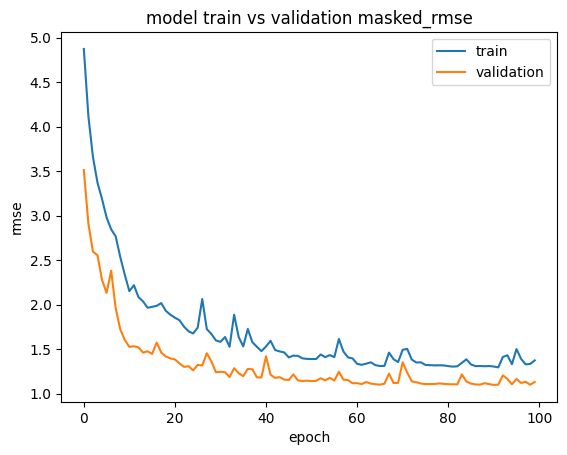

In [ ]:
rmse = hist_Autorec_anime.history['masked_rmse_clip_10']
val_rmse = hist_Autorec_anime.history['val_masked_rmse_clip_10']
plt.plot(np.arange(0, len(rmse), 1), rmse[0:])
plt.plot(np.arange(0, len(val_rmse), 1), val_rmse[0:])
plt.title('model train vs validation masked_rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
test_result = anime_model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

157/157 [==============================] - 5s 31ms/step - loss: 3.2717 - masked_mse_clip_10: 2.4835 - masked_rmse_clip_10: 1.1179 - masked_se_clip_10: 20.0692
[3.2717459201812744, 2.4835331439971924, 1.1179330348968506, 20.06924057006836]


# Fold Anime U-AutoRec

In [14]:
import gc

In [12]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=True,random_state=999613182)
folds=[] #train validate, test
for train_idx, rem_idx in kf.split(datContent):
  train=[]
  validate=[]
  test=[]
  n = len(rem_idx)//2
  valid_idx=rem_idx[0:n]
  test_idx=rem_idx[n:]
  for i in train_idx:
    train.append(datContent[i])
  for i in valid_idx:
    validate.append(datContent[i])
  for i in test_idx:
    test.append(datContent[i])
  fold=[train,validate,test]
  print(len(fold[0]),len(fold[1]),len(fold[2]))
  folds.append(fold)

335954 41994 41995
335954 41994 41995
335954 41994 41995
335955 41994 41994
335955 41994 41994


In [17]:
f=0
for fold in folds:
  f+=1
  gc.collect()
  users_items_matrix_train_zero = my_proc(fold[0])
  users_items_matrix_train_avg = my_proc_avg(fold[0])
  users_items_matrix_validate = my_proc(fold[1])
  users_items_matrix_test = my_proc(fold[2])
  model = AutoRec(users_items_matrix_train_zero, 0.0005, 'relu','linear')
  model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
  hist_Autorec = model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                epochs=50,
                batch_size=256,
                verbose = 1, 
                validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
  test_result = model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print("Fold no: ",f,test_result)

Epoch 1/50
20/20 [==============================] - 8s 363ms/step - loss: 30.6511 - masked_mse_clip_10: 14.7297 - masked_rmse_clip_10: 3.3583 - val_loss: 2.7206 - val_masked_mse_clip_10: 1.8636 - val_masked_rmse_clip_10: 0.7948
Epoch 2/50
20/20 [==============================] - 5s 252ms/step - loss: 2.6332 - masked_mse_clip_10: 2.0124 - masked_rmse_clip_10: 1.2807 - val_loss: 1.6248 - val_masked_mse_clip_10: 1.1097 - val_masked_rmse_clip_10: 0.5765
Epoch 3/50
20/20 [==============================] - 6s 289ms/step - loss: 2.0665 - masked_mse_clip_10: 1.5508 - masked_rmse_clip_10: 1.1211 - val_loss: 1.6197 - val_masked_mse_clip_10: 1.1057 - val_masked_rmse_clip_10: 0.5784
Epoch 4/50
20/20 [==============================] - 5s 251ms/step - loss: 2.0048 - masked_mse_clip_10: 1.5049 - masked_rmse_clip_10: 1.1031 - val_loss: 1.5621 - val_masked_mse_clip_10: 1.0376 - val_masked_rmse_clip_10: 0.5500
Epoch 5/50
20/20 [==============================] - 6s 330ms/step - loss: 2.0111 - masked_mse_

Epoch 1/50
20/20 [==============================] - 7s 333ms/step - loss: 27.9890 - masked_mse_clip_10: 14.0858 - masked_rmse_clip_10: 3.2984 - val_loss: 2.7993 - val_masked_mse_clip_10: 1.9501 - val_masked_rmse_clip_10: 0.8037
Epoch 2/50
20/20 [==============================] - 6s 311ms/step - loss: 2.6935 - masked_mse_clip_10: 2.0775 - masked_rmse_clip_10: 1.2947 - val_loss: 1.8129 - val_masked_mse_clip_10: 1.2439 - val_masked_rmse_clip_10: 0.5954
Epoch 3/50
20/20 [==============================] - 6s 311ms/step - loss: 2.0108 - masked_mse_clip_10: 1.5113 - masked_rmse_clip_10: 1.1062 - val_loss: 1.7223 - val_masked_mse_clip_10: 1.1645 - val_masked_rmse_clip_10: 0.5664
Epoch 4/50
20/20 [==============================] - 6s 318ms/step - loss: 1.9384 - masked_mse_clip_10: 1.4549 - masked_rmse_clip_10: 1.0848 - val_loss: 1.7529 - val_masked_mse_clip_10: 1.2067 - val_masked_rmse_clip_10: 0.5874
Epoch 5/50
20/20 [==============================] - 6s 280ms/step - loss: 2.0539 - masked_mse_

Epoch 1/50
20/20 [==============================] - 6s 266ms/step - loss: 25.1290 - masked_mse_clip_10: 12.6992 - masked_rmse_clip_10: 3.1217 - val_loss: 2.6200 - val_masked_mse_clip_10: 1.7507 - val_masked_rmse_clip_10: 0.7634
Epoch 2/50
20/20 [==============================] - 6s 308ms/step - loss: 2.6557 - masked_mse_clip_10: 2.0564 - masked_rmse_clip_10: 1.2973 - val_loss: 1.6251 - val_masked_mse_clip_10: 1.1540 - val_masked_rmse_clip_10: 0.5925
Epoch 3/50
20/20 [==============================] - 6s 310ms/step - loss: 1.9753 - masked_mse_clip_10: 1.5252 - masked_rmse_clip_10: 1.1135 - val_loss: 1.6366 - val_masked_mse_clip_10: 1.1054 - val_masked_rmse_clip_10: 0.5670
Epoch 4/50
20/20 [==============================] - 6s 308ms/step - loss: 1.9899 - masked_mse_clip_10: 1.5258 - masked_rmse_clip_10: 1.1130 - val_loss: 1.5850 - val_masked_mse_clip_10: 1.1142 - val_masked_rmse_clip_10: 0.5788
Epoch 5/50
20/20 [==============================] - 5s 242ms/step - loss: 1.9726 - masked_mse_

Epoch 1/50
20/20 [==============================] - 6s 269ms/step - loss: 33.6859 - masked_mse_clip_10: 15.7880 - masked_rmse_clip_10: 3.5083 - val_loss: 2.6057 - val_masked_mse_clip_10: 1.7461 - val_masked_rmse_clip_10: 0.7608
Epoch 2/50
20/20 [==============================] - 5s 241ms/step - loss: 2.6490 - masked_mse_clip_10: 2.0158 - masked_rmse_clip_10: 1.2795 - val_loss: 1.7588 - val_masked_mse_clip_10: 1.2024 - val_masked_rmse_clip_10: 0.6014
Epoch 3/50
20/20 [==============================] - 7s 340ms/step - loss: 2.0271 - masked_mse_clip_10: 1.5155 - masked_rmse_clip_10: 1.1065 - val_loss: 1.6653 - val_masked_mse_clip_10: 1.1095 - val_masked_rmse_clip_10: 0.5673
Epoch 4/50
20/20 [==============================] - 5s 241ms/step - loss: 2.0032 - masked_mse_clip_10: 1.4820 - masked_rmse_clip_10: 1.0934 - val_loss: 1.6518 - val_masked_mse_clip_10: 1.1022 - val_masked_rmse_clip_10: 0.5635
Epoch 5/50
20/20 [==============================] - 7s 337ms/step - loss: 2.1923 - masked_mse_

Epoch 1/50
20/20 [==============================] - 7s 345ms/step - loss: 30.1795 - masked_mse_clip_10: 14.9599 - masked_rmse_clip_10: 3.4129 - val_loss: 2.9971 - val_masked_mse_clip_10: 1.9246 - val_masked_rmse_clip_10: 0.8096
Epoch 2/50
20/20 [==============================] - 5s 240ms/step - loss: 2.7582 - masked_mse_clip_10: 2.0590 - masked_rmse_clip_10: 1.2952 - val_loss: 1.8157 - val_masked_mse_clip_10: 1.2856 - val_masked_rmse_clip_10: 0.6413
Epoch 3/50
20/20 [==============================] - 6s 311ms/step - loss: 2.0785 - masked_mse_clip_10: 1.5633 - masked_rmse_clip_10: 1.1276 - val_loss: 1.6054 - val_masked_mse_clip_10: 1.0735 - val_masked_rmse_clip_10: 0.5622
Epoch 4/50
20/20 [==============================] - 6s 309ms/step - loss: 2.0584 - masked_mse_clip_10: 1.5357 - masked_rmse_clip_10: 1.1168 - val_loss: 1.6142 - val_masked_mse_clip_10: 1.0805 - val_masked_rmse_clip_10: 0.5648
Epoch 5/50
20/20 [==============================] - 5s 271ms/step - loss: 2.0700 - masked_mse_

## I-AutoRec

In [18]:
def my_proc_2(cont,init):
  matrix = np.full((max_anime,max_user),init)
  for r in cont:
    matrix[int(r[1])-1,int(r[0])-1] = float(r[2])
  return matrix

def my_proc_avg_2(cont): 
  matrix = np.full((max_anime,max_user),0)
  for r in cont:
    matrix[int(r[1])-1,int(r[0])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [ ]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 
print(len(train_df),len(test_df),len(validate_df))

340153 41995 37795


In [22]:
val=0
users_items_matrix_train_zero = my_proc_2(train_df,val)
users_items_matrix_train_avg = my_proc_avg_2(train_df)
users_items_matrix_validate = my_proc_2(validate_df,val)
users_items_matrix_test = my_proc_2(test_df,val)

In [23]:
users_items_matrix_train_zero.shape

(7390, 5000)

In [ ]:
model2_anime = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

model2_anime.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10,masked_se_clip_10])
 
model2_anime.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 5000)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               2500500   
                                                                 
 UserScorePred (Dense)       (None, 5000)              2505000   
                                                                 
Total params: 5,005,500
Trainable params: 5,005,500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec2_anime = model2_anime.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])

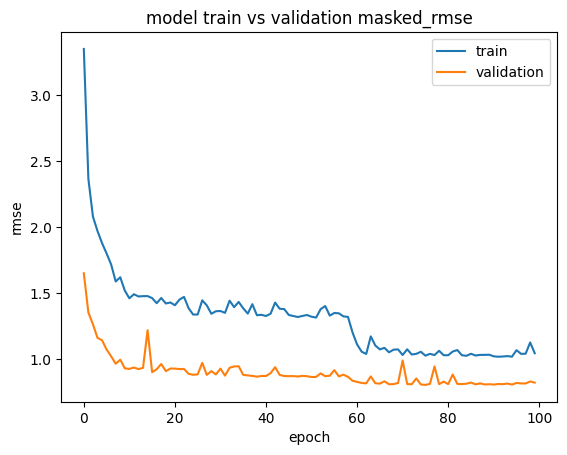

In [ ]:
rmse = hist_Autorec2_anime.history['masked_rmse_clip_10']
val_rmse = hist_Autorec2_anime.history['val_masked_rmse_clip_10']
plt.plot(np.arange(0, len(rmse), 1), rmse[0:])
plt.plot(np.arange(0, len(val_rmse), 1), val_rmse[0:])
plt.title('model train vs validation masked_rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
test_result = model2_anime.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

231/231 [==============================] - 4s 17ms/step - loss: 2.2623 - masked_mse_clip_10: 1.7952 - masked_rmse_clip_10: 0.8297 - masked_se_clip_10: 11.7623
[2.262280225753784, 1.7951539754867554, 0.8297481536865234, 11.762250900268555]


In [ ]:
activations=['linear','sigmoid','relu']
for outer_activation in activations:
  for inner_activation in activations:
    gc.collect()
    model2_anime = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')
    model2_anime.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
    hist_Autorec2_anime = model2_anime.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=60,
                  batch_size=256,
                  verbose = 1, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
    test_result = model2_anime.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
    print("first: ", outer_activation,"sec: ",inner_activation)
    print(test_result)
    gc.collect()

Epoch 1/60
29/29 [==============================] - 10s 339ms/step - loss: 22.5588 - masked_mse_clip_10: 12.7391 - masked_rmse_clip_10: 3.1592 - val_loss: 7.3117 - val_masked_mse_clip_10: 4.7535 - val_masked_rmse_clip_10: 1.4146
Epoch 2/60
29/29 [==============================] - 7s 244ms/step - loss: 9.1604 - masked_mse_clip_10: 5.6917 - masked_rmse_clip_10: 2.0552 - val_loss: 5.3853 - val_masked_mse_clip_10: 3.5296 - val_masked_rmse_clip_10: 1.1816
Epoch 3/60
29/29 [==============================] - 9s 305ms/step - loss: 6.8668 - masked_mse_clip_10: 4.2778 - masked_rmse_clip_10: 1.7471 - val_loss: 4.5751 - val_masked_mse_clip_10: 2.9843 - val_masked_rmse_clip_10: 1.0692
Epoch 4/60
29/29 [==============================] - 8s 264ms/step - loss: 6.0740 - masked_mse_clip_10: 3.7454 - masked_rmse_clip_10: 1.6174 - val_loss: 4.4442 - val_masked_mse_clip_10: 2.9173 - val_masked_rmse_clip_10: 1.0521
Epoch 5/60
29/29 [==============================] - 8s 268ms/step - loss: 5.8383 - masked_mse

Epoch 1/60
29/29 [==============================] - 12s 385ms/step - loss: 29.6080 - masked_mse_clip_10: 15.8683 - masked_rmse_clip_10: 3.6047 - val_loss: 10.0894 - val_masked_mse_clip_10: 6.4177 - val_masked_rmse_clip_10: 1.6786
Epoch 2/60
29/29 [==============================] - 8s 267ms/step - loss: 14.3032 - masked_mse_clip_10: 8.6980 - masked_rmse_clip_10: 2.5524 - val_loss: 7.8460 - val_masked_mse_clip_10: 4.9405 - val_masked_rmse_clip_10: 1.4100
Epoch 3/60
29/29 [==============================] - 9s 306ms/step - loss: 11.5022 - masked_mse_clip_10: 7.0138 - masked_rmse_clip_10: 2.2471 - val_loss: 7.0285 - val_masked_mse_clip_10: 4.7085 - val_masked_rmse_clip_10: 1.4128
Epoch 4/60
29/29 [==============================] - 10s 369ms/step - loss: 8.9636 - masked_mse_clip_10: 5.6468 - masked_rmse_clip_10: 1.9801 - val_loss: 5.1577 - val_masked_mse_clip_10: 3.3408 - val_masked_rmse_clip_10: 1.1150
Epoch 5/60
29/29 [==============================] - 8s 265ms/step - loss: 7.6055 - masked

Epoch 1/60
29/29 [==============================] - 10s 313ms/step - loss: 31.3153 - masked_mse_clip_10: 13.2320 - masked_rmse_clip_10: 3.2403 - val_loss: 8.1265 - val_masked_mse_clip_10: 5.3831 - val_masked_rmse_clip_10: 1.5116
Epoch 2/60
29/29 [==============================] - 8s 290ms/step - loss: 9.7499 - masked_mse_clip_10: 6.2434 - masked_rmse_clip_10: 2.1018 - val_loss: 5.5610 - val_masked_mse_clip_10: 3.5814 - val_masked_rmse_clip_10: 1.1661
Epoch 3/60
29/29 [==============================] - 7s 247ms/step - loss: 7.5481 - masked_mse_clip_10: 4.7478 - masked_rmse_clip_10: 1.7710 - val_loss: 4.9204 - val_masked_mse_clip_10: 3.1759 - val_masked_rmse_clip_10: 1.0756
Epoch 4/60
29/29 [==============================] - 9s 311ms/step - loss: 6.7149 - masked_mse_clip_10: 4.2209 - masked_rmse_clip_10: 1.6482 - val_loss: 4.5291 - val_masked_mse_clip_10: 2.9454 - val_masked_rmse_clip_10: 1.0239
Epoch 5/60
29/29 [==============================] - 8s 270ms/step - loss: 6.3346 - masked_mse

Epoch 1/60
29/29 [==============================] - 10s 333ms/step - loss: 27.7275 - masked_mse_clip_10: 13.2095 - masked_rmse_clip_10: 3.2227 - val_loss: 7.8409 - val_masked_mse_clip_10: 5.2256 - val_masked_rmse_clip_10: 1.4986
Epoch 2/60
29/29 [==============================] - 11s 371ms/step - loss: 10.4167 - masked_mse_clip_10: 6.5239 - masked_rmse_clip_10: 2.1597 - val_loss: 6.3557 - val_masked_mse_clip_10: 4.1654 - val_masked_rmse_clip_10: 1.2992
Epoch 3/60
29/29 [==============================] - 7s 248ms/step - loss: 8.8486 - masked_mse_clip_10: 5.4124 - masked_rmse_clip_10: 1.9131 - val_loss: 5.6031 - val_masked_mse_clip_10: 3.6419 - val_masked_rmse_clip_10: 1.1895
Epoch 4/60
29/29 [==============================] - 9s 295ms/step - loss: 8.2062 - masked_mse_clip_10: 5.0353 - masked_rmse_clip_10: 1.8338 - val_loss: 5.0615 - val_masked_mse_clip_10: 3.2291 - val_masked_rmse_clip_10: 1.0822
Epoch 5/60
29/29 [==============================] - 8s 293ms/step - loss: 7.7685 - masked_m

Epoch 1/60
29/29 [==============================] - 12s 381ms/step - loss: 40.4723 - masked_mse_clip_10: 18.1563 - masked_rmse_clip_10: 3.8975 - val_loss: 15.6751 - val_masked_mse_clip_10: 9.7033 - val_masked_rmse_clip_10: 2.1355
Epoch 2/60
29/29 [==============================] - 7s 241ms/step - loss: 21.6048 - masked_mse_clip_10: 12.9582 - masked_rmse_clip_10: 3.1893 - val_loss: 12.2843 - val_masked_mse_clip_10: 7.4854 - val_masked_rmse_clip_10: 1.7996
Epoch 3/60
29/29 [==============================] - 8s 286ms/step - loss: 17.8962 - masked_mse_clip_10: 10.7481 - masked_rmse_clip_10: 2.8405 - val_loss: 9.9412 - val_masked_mse_clip_10: 6.1702 - val_masked_rmse_clip_10: 1.6023
Epoch 4/60
29/29 [==============================] - 10s 357ms/step - loss: 14.7504 - masked_mse_clip_10: 8.9585 - masked_rmse_clip_10: 2.5549 - val_loss: 8.4524 - val_masked_mse_clip_10: 5.3029 - val_masked_rmse_clip_10: 1.4560
Epoch 5/60
29/29 [==============================] - 8s 266ms/step - loss: 11.9139 - m

Epoch 1/60
29/29 [==============================] - 10s 294ms/step - loss: 30.1653 - masked_mse_clip_10: 14.2828 - masked_rmse_clip_10: 3.3853 - val_loss: 9.1450 - val_masked_mse_clip_10: 5.9271 - val_masked_rmse_clip_10: 1.5979
Epoch 2/60
29/29 [==============================] - 8s 286ms/step - loss: 12.5911 - masked_mse_clip_10: 7.7735 - masked_rmse_clip_10: 2.3871 - val_loss: 7.2415 - val_masked_mse_clip_10: 4.5927 - val_masked_rmse_clip_10: 1.3470
Epoch 3/60
29/29 [==============================] - 8s 266ms/step - loss: 10.4335 - masked_mse_clip_10: 6.3849 - masked_rmse_clip_10: 2.1131 - val_loss: 6.1062 - val_masked_mse_clip_10: 3.8610 - val_masked_rmse_clip_10: 1.1994
Epoch 4/60
29/29 [==============================] - 8s 287ms/step - loss: 9.2307 - masked_mse_clip_10: 5.6732 - masked_rmse_clip_10: 1.9592 - val_loss: 5.5204 - val_masked_mse_clip_10: 3.5256 - val_masked_rmse_clip_10: 1.1416
Epoch 5/60
29/29 [==============================] - 9s 306ms/step - loss: 8.3209 - masked_m

Epoch 1/60
29/29 [==============================] - 12s 392ms/step - loss: 33.9932 - masked_mse_clip_10: 15.6445 - masked_rmse_clip_10: 3.5746 - val_loss: 11.0365 - val_masked_mse_clip_10: 7.1065 - val_masked_rmse_clip_10: 1.7818
Epoch 2/60
29/29 [==============================] - 8s 266ms/step - loss: 13.9973 - masked_mse_clip_10: 8.6314 - masked_rmse_clip_10: 2.5187 - val_loss: 7.5891 - val_masked_mse_clip_10: 4.8153 - val_masked_rmse_clip_10: 1.3989
Epoch 3/60
29/29 [==============================] - 8s 285ms/step - loss: 10.8585 - masked_mse_clip_10: 6.6078 - masked_rmse_clip_10: 2.1366 - val_loss: 6.3932 - val_masked_mse_clip_10: 4.0426 - val_masked_rmse_clip_10: 1.2455
Epoch 4/60
29/29 [==============================] - 8s 283ms/step - loss: 9.4795 - masked_mse_clip_10: 5.7637 - masked_rmse_clip_10: 1.9640 - val_loss: 5.8202 - val_masked_mse_clip_10: 3.8288 - val_masked_rmse_clip_10: 1.2229
Epoch 5/60
29/29 [==============================] - 8s 265ms/step - loss: 7.9934 - masked_

Epoch 1/60
29/29 [==============================] - 9s 295ms/step - loss: 30.2866 - masked_mse_clip_10: 12.6308 - masked_rmse_clip_10: 3.1451 - val_loss: 7.5665 - val_masked_mse_clip_10: 5.0177 - val_masked_rmse_clip_10: 1.4546
Epoch 2/60
29/29 [==============================] - 9s 316ms/step - loss: 9.6839 - masked_mse_clip_10: 6.1026 - masked_rmse_clip_10: 2.0699 - val_loss: 5.4352 - val_masked_mse_clip_10: 3.5112 - val_masked_rmse_clip_10: 1.1469
Epoch 3/60
29/29 [==============================] - 10s 362ms/step - loss: 7.9974 - masked_mse_clip_10: 4.9298 - masked_rmse_clip_10: 1.8003 - val_loss: 4.9305 - val_masked_mse_clip_10: 3.1641 - val_masked_rmse_clip_10: 1.0627
Epoch 4/60
29/29 [==============================] - 7s 250ms/step - loss: 7.4321 - masked_mse_clip_10: 4.5848 - masked_rmse_clip_10: 1.7138 - val_loss: 4.6388 - val_masked_mse_clip_10: 3.0135 - val_masked_rmse_clip_10: 1.0343
Epoch 5/60
29/29 [==============================] - 8s 292ms/step - loss: 6.7119 - masked_mse

Epoch 1/60
29/29 [==============================] - 10s 335ms/step - loss: 34.3369 - masked_mse_clip_10: 16.3463 - masked_rmse_clip_10: 3.6788 - val_loss: 12.4066 - val_masked_mse_clip_10: 7.9206 - val_masked_rmse_clip_10: 1.8982
Epoch 2/60
29/29 [==============================] - 8s 268ms/step - loss: 16.0942 - masked_mse_clip_10: 9.9062 - masked_rmse_clip_10: 2.7384 - val_loss: 8.9651 - val_masked_mse_clip_10: 5.7418 - val_masked_rmse_clip_10: 1.5567
Epoch 3/60
29/29 [==============================] - 8s 288ms/step - loss: 12.6181 - masked_mse_clip_10: 7.6684 - masked_rmse_clip_10: 2.3499 - val_loss: 7.3378 - val_masked_mse_clip_10: 4.5996 - val_masked_rmse_clip_10: 1.3423
Epoch 4/60
29/29 [==============================] - 9s 309ms/step - loss: 10.9779 - masked_mse_clip_10: 6.7087 - masked_rmse_clip_10: 2.1595 - val_loss: 6.3014 - val_masked_mse_clip_10: 4.0074 - val_masked_rmse_clip_10: 1.2279
Epoch 5/60
29/29 [==============================] - 8s 269ms/step - loss: 9.5765 - masked

## I AutoRec Folds Anime

In [26]:
f=0
for fold in folds:
  f+=1
  gc.collect()
  val=0
  users_items_matrix_train_zero = my_proc_2(fold[0],val)
  users_items_matrix_train_avg = my_proc_avg_2(fold[0])
  users_items_matrix_validate = my_proc_2(fold[1],val)
  users_items_matrix_test = my_proc_2(fold[2],val)
  model = AutoRec(users_items_matrix_train_zero, 0.0005, 'sigmoid','relu')
  model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
  hist_Autorec = model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                epochs=50,
                batch_size=256,
                verbose = 1, 
                validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
  test_result = model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print("Fold no: ",f,test_result)

Epoch 1/50
29/29 [==============================] - 7s 223ms/step - loss: 29.3788 - masked_mse_clip_10: 24.2939 - masked_rmse_clip_10: 4.5474 - val_loss: 11.9938 - val_masked_mse_clip_10: 9.5710 - val_masked_rmse_clip_10: 2.1212
Epoch 2/50
29/29 [==============================] - 7s 256ms/step - loss: 10.9358 - masked_mse_clip_10: 9.0871 - masked_rmse_clip_10: 2.6429 - val_loss: 3.3051 - val_masked_mse_clip_10: 2.6543 - val_masked_rmse_clip_10: 1.0696
Epoch 3/50
29/29 [==============================] - 5s 157ms/step - loss: 3.1488 - masked_mse_clip_10: 2.4736 - masked_rmse_clip_10: 1.3871 - val_loss: 2.1661 - val_masked_mse_clip_10: 1.4824 - val_masked_rmse_clip_10: 0.8147
Epoch 4/50
29/29 [==============================] - 5s 182ms/step - loss: 2.6626 - masked_mse_clip_10: 1.9758 - masked_rmse_clip_10: 1.2476 - val_loss: 2.1336 - val_masked_mse_clip_10: 1.4455 - val_masked_rmse_clip_10: 0.8066
Epoch 5/50
29/29 [==============================] - 5s 159ms/step - loss: 2.6206 - masked_ms

Epoch 1/50
29/29 [==============================] - 6s 192ms/step - loss: 30.1380 - masked_mse_clip_10: 24.9841 - masked_rmse_clip_10: 4.6260 - val_loss: 12.1480 - val_masked_mse_clip_10: 9.7454 - val_masked_rmse_clip_10: 2.1444
Epoch 2/50
29/29 [==============================] - 5s 160ms/step - loss: 10.8083 - masked_mse_clip_10: 9.0553 - masked_rmse_clip_10: 2.6300 - val_loss: 3.5308 - val_masked_mse_clip_10: 2.8252 - val_masked_rmse_clip_10: 1.0982
Epoch 3/50
29/29 [==============================] - 6s 207ms/step - loss: 3.1973 - masked_mse_clip_10: 2.5258 - masked_rmse_clip_10: 1.3983 - val_loss: 2.1050 - val_masked_mse_clip_10: 1.4235 - val_masked_rmse_clip_10: 0.7908
Epoch 4/50
29/29 [==============================] - 5s 161ms/step - loss: 2.6597 - masked_mse_clip_10: 1.9790 - masked_rmse_clip_10: 1.2459 - val_loss: 2.1457 - val_masked_mse_clip_10: 1.4646 - val_masked_rmse_clip_10: 0.8109
Epoch 5/50
29/29 [==============================] - 5s 161ms/step - loss: 2.6483 - masked_ms

Epoch 1/50
29/29 [==============================] - 7s 217ms/step - loss: 27.4677 - masked_mse_clip_10: 23.0655 - masked_rmse_clip_10: 4.3932 - val_loss: 9.9136 - val_masked_mse_clip_10: 7.9823 - val_masked_rmse_clip_10: 1.9217
Epoch 2/50
29/29 [==============================] - 5s 160ms/step - loss: 9.6639 - masked_mse_clip_10: 8.0167 - masked_rmse_clip_10: 2.4610 - val_loss: 2.9344 - val_masked_mse_clip_10: 2.2892 - val_masked_rmse_clip_10: 0.9910
Epoch 3/50
29/29 [==============================] - 4s 157ms/step - loss: 3.1225 - masked_mse_clip_10: 2.4568 - masked_rmse_clip_10: 1.3816 - val_loss: 2.1964 - val_masked_mse_clip_10: 1.5151 - val_masked_rmse_clip_10: 0.8199
Epoch 4/50
29/29 [==============================] - 5s 177ms/step - loss: 2.6605 - masked_mse_clip_10: 1.9687 - masked_rmse_clip_10: 1.2441 - val_loss: 2.0982 - val_masked_mse_clip_10: 1.3981 - val_masked_rmse_clip_10: 0.7886
Epoch 5/50
29/29 [==============================] - 4s 155ms/step - loss: 2.5951 - masked_mse_

Epoch 1/50
29/29 [==============================] - 6s 182ms/step - loss: 30.0054 - masked_mse_clip_10: 24.7273 - masked_rmse_clip_10: 4.5955 - val_loss: 11.6693 - val_masked_mse_clip_10: 9.3664 - val_masked_rmse_clip_10: 2.1052
Epoch 2/50
29/29 [==============================] - 4s 155ms/step - loss: 10.6160 - masked_mse_clip_10: 8.8694 - masked_rmse_clip_10: 2.6006 - val_loss: 3.1378 - val_masked_mse_clip_10: 2.4998 - val_masked_rmse_clip_10: 1.0393
Epoch 3/50
29/29 [==============================] - 5s 179ms/step - loss: 3.1206 - masked_mse_clip_10: 2.4714 - masked_rmse_clip_10: 1.3888 - val_loss: 2.1348 - val_masked_mse_clip_10: 1.4654 - val_masked_rmse_clip_10: 0.8060
Epoch 4/50
29/29 [==============================] - 5s 157ms/step - loss: 2.6296 - masked_mse_clip_10: 1.9623 - masked_rmse_clip_10: 1.2418 - val_loss: 2.0584 - val_masked_mse_clip_10: 1.3920 - val_masked_rmse_clip_10: 0.7880
Epoch 5/50
29/29 [==============================] - 6s 203ms/step - loss: 2.5665 - masked_ms

Epoch 1/50
29/29 [==============================] - 6s 173ms/step - loss: 29.6237 - masked_mse_clip_10: 24.6097 - masked_rmse_clip_10: 4.5653 - val_loss: 12.9044 - val_masked_mse_clip_10: 10.1878 - val_masked_rmse_clip_10: 2.1903
Epoch 2/50
29/29 [==============================] - 5s 159ms/step - loss: 11.3742 - masked_mse_clip_10: 9.4288 - masked_rmse_clip_10: 2.6782 - val_loss: 4.0647 - val_masked_mse_clip_10: 3.2724 - val_masked_rmse_clip_10: 1.1826
Epoch 3/50
29/29 [==============================] - 5s 178ms/step - loss: 3.3642 - masked_mse_clip_10: 2.6969 - masked_rmse_clip_10: 1.4383 - val_loss: 2.2286 - val_masked_mse_clip_10: 1.5634 - val_masked_rmse_clip_10: 0.8296
Epoch 4/50
29/29 [==============================] - 5s 159ms/step - loss: 2.6851 - masked_mse_clip_10: 2.0134 - masked_rmse_clip_10: 1.2543 - val_loss: 2.1445 - val_masked_mse_clip_10: 1.4605 - val_masked_rmse_clip_10: 0.8047
Epoch 5/50
29/29 [==============================] - 6s 207ms/step - loss: 2.6218 - masked_m

## Deep Autoencoder

In [ ]:
datContent = [i.strip().split() for i in open("book_ratings.dat").readlines()][1:]

In [ ]:
max_user=0
max_book=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_book=max(max_book,int(r[1]))
print(max_book,max_user)

17384 2945


In [ ]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 
users_items_matrix_train_zero = my_proc(train_df)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df)
users_items_matrix_test = my_proc(test_df)

In [ ]:
 def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model
     

In [ ]:
layers = [256, 512, 256]
#layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

In [ ]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

Epoch 1/100
12/12 - 13s - loss: 30.2253 - masked_rmse_clip: 3.1124 - val_loss: 27.2416 - val_masked_rmse_clip: 2.8862 - 13s/epoch - 1s/step
Epoch 2/100
12/12 - 12s - loss: 22.4547 - masked_rmse_clip: 2.8399 - val_loss: 12.0108 - val_masked_rmse_clip: 1.8007 - 12s/epoch - 991ms/step
Epoch 3/100
12/12 - 9s - loss: 8.1648 - masked_rmse_clip: 1.6691 - val_loss: 7.6539 - val_masked_rmse_clip: 1.6250 - 9s/epoch - 728ms/step
Epoch 4/100
12/12 - 9s - loss: 4.4644 - masked_rmse_clip: 1.5149 - val_loss: 5.6070 - val_masked_rmse_clip: 1.5148 - 9s/epoch - 737ms/step
Epoch 5/100
12/12 - 9s - loss: 3.2745 - masked_rmse_clip: 1.4729 - val_loss: 5.5209 - val_masked_rmse_clip: 1.5184 - 9s/epoch - 719ms/step
Epoch 6/100
12/12 - 7s - loss: 3.0402 - masked_rmse_clip: 1.4658 - val_loss: 5.3830 - val_masked_rmse_clip: 1.5172 - 7s/epoch - 619ms/step
Epoch 7/100
12/12 - 8s - loss: 2.8010 - masked_rmse_clip: 1.4619 - val_loss: 5.2214 - val_masked_rmse_clip: 1.5130 - 8s/epoch - 692ms/step
Epoch 8/100
12/12 - 10

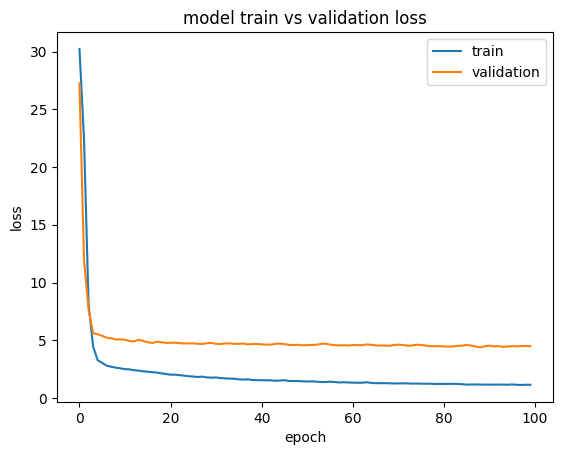

In [ ]:
show_error(hist_Deep_AE,0)